# Задача:
### Построить модель банковского скоринга на основе имеющихся данных и оценить качество модели 

In [353]:
# Импортируем нужные библиотеки

from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
    
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score

from datetime import datetime

from sklearn.model_selection import GridSearchCV

In [354]:
#Фиксируем сразу random state для воспроизводимости результата

random_state = 42

In [355]:
df = pd.read_csv("train_5.csv")

# Данные по признакам

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [356]:
#Для удобства в будущем разделим все столбцы на категориальные, бинарные и числовые
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt','income', 'score_bki']

# Имплементация функций для обработки данных

In [357]:
#Конвертация даты из строки в datetime
def str_time_to_datetime(x):
    return datetime.strptime(x, "%d%b%Y")

# Знакомство с данными

In [358]:
df.info()
#Пропуски есть только в поле education 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

<AxesSubplot:>

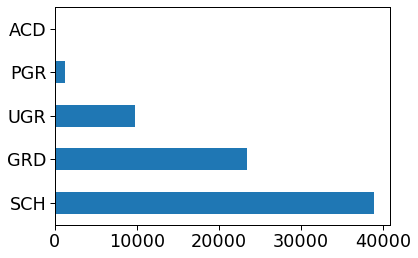

In [359]:
#Оценим имеющиеся значения в education для замены пропусков
df['education'].value_counts().plot.barh()

In [360]:
#Заменим пропуски на самое частое значение (в данном случае - SCH)
df['education'].fillna(value = df['education'].mode().values[0], inplace= True)
print(df['education'].mode().values[0])

SCH


<AxesSubplot:>

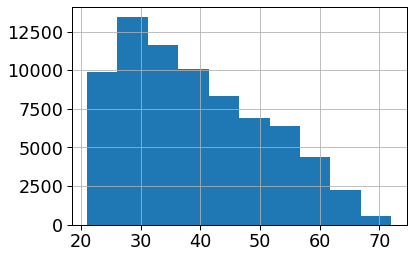

In [361]:
df['age'].hist()

<AxesSubplot:>

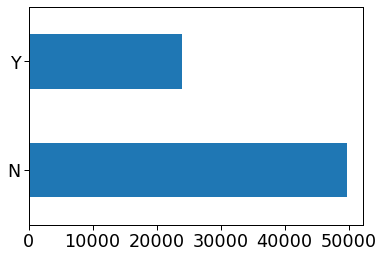

In [362]:
df['car'].value_counts().plot.barh()

<AxesSubplot:>

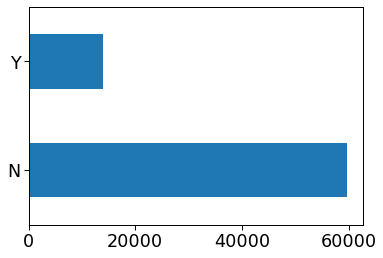

In [363]:
df['car_type'].value_counts().plot.barh()

<AxesSubplot:>

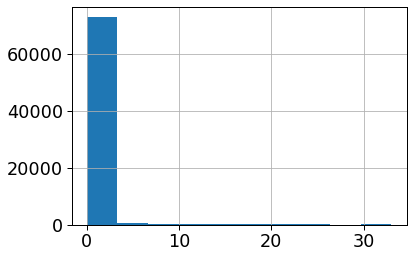

In [364]:
df['decline_app_cnt'].hist()

<AxesSubplot:>

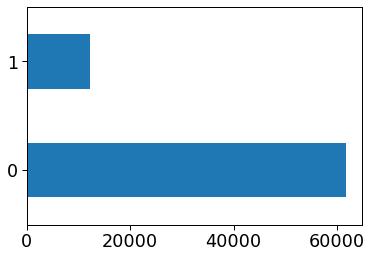

In [365]:
df['good_work'].value_counts().plot.barh()

<AxesSubplot:>

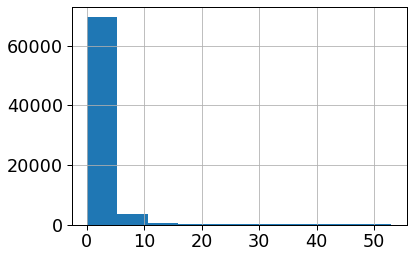

In [366]:
df['bki_request_cnt'].hist()

<AxesSubplot:>

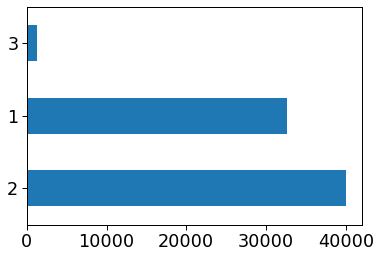

In [367]:
df['home_address'].value_counts().plot.barh()

<AxesSubplot:>

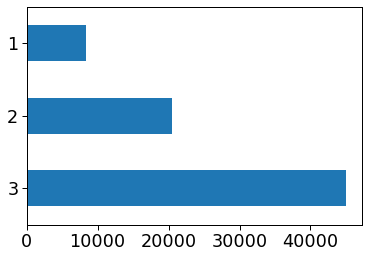

In [368]:
df['work_address'].value_counts().plot.barh()

<AxesSubplot:>

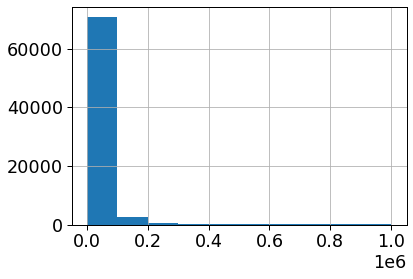

In [369]:
df['income'].hist()

<AxesSubplot:>

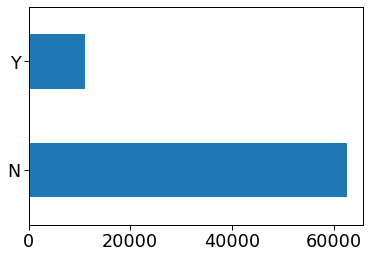

In [370]:
df['foreign_passport'].value_counts().plot.barh()

<AxesSubplot:>

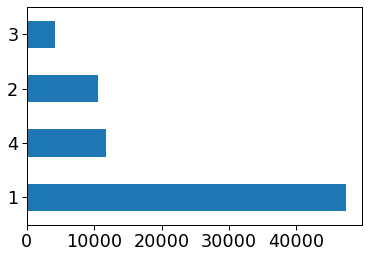

In [371]:
df['sna'].value_counts().plot.barh()

<AxesSubplot:>

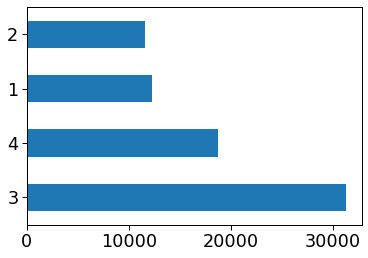

In [372]:
df['first_time'].value_counts().plot.barh()

<AxesSubplot:>

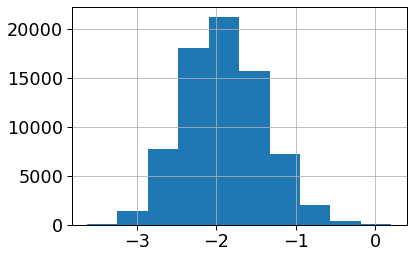

In [373]:
df['score_bki'].hist()

<AxesSubplot:>

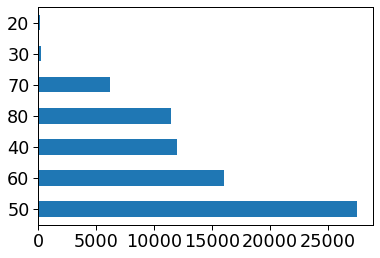

In [374]:
df['region_rating'].value_counts().plot.barh()

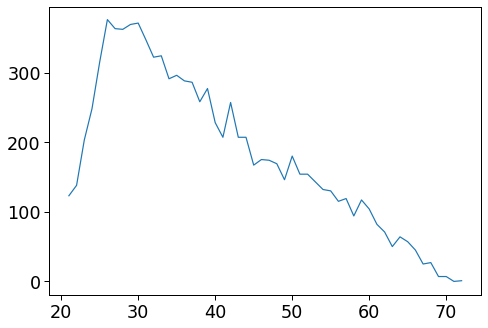

In [375]:
fig = plt.figure()

ages = df.groupby('age', as_index = False)['default'].sum()
x1 = ages['age'].values
x2 = ages['default'].values

axes = fig.add_axes([0,0,1,1])
axes.plot(x1, x2) 

# Feature engineering

In [376]:
#На основе графика зависимости кол-ва дефолтных клиентов от возраста создадим новый признак 
#Между 23 и 43 годами наиболее высокая концентрация должников
df['crit_age']=df['age'].apply(lambda x: 1 if x>23 and x<43 else 0)

In [377]:
#Преобразуем поле с датами в разницу между датой подачи самой первой заявки и текущей 
df['app_date']=df['app_date'].apply(str_time_to_datetime)
min_date = df['app_date'].min()

df['delta_app_date'] = df['app_date'].apply(lambda x: (x - min_date).days)

In [378]:
#Обновим списки переменных
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'crit_age']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt','income', 'score_bki', 'delta_app_date']

<AxesSubplot:>

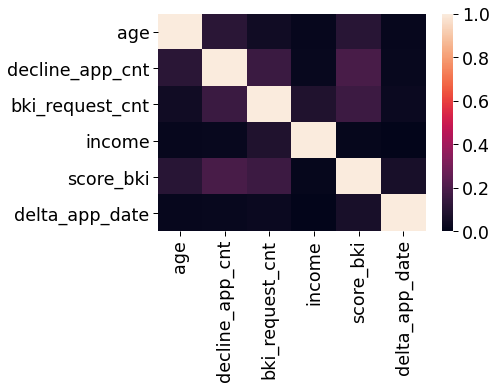

In [379]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)
#Высокой корреляции числовых признаков между собой не обнаружено 

<AxesSubplot:>

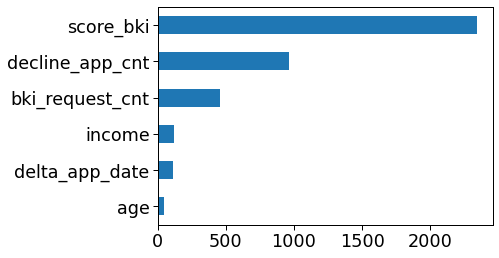

In [380]:
#Определим значимость числовых переменных
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
#Абсолютным лидером оказывается скор.балл БКИ

# Преобразование признаков 

In [381]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [382]:
label_encoder = LabelEncoder()

df['education'] = label_encoder.fit_transform(df['education'])

<AxesSubplot:>

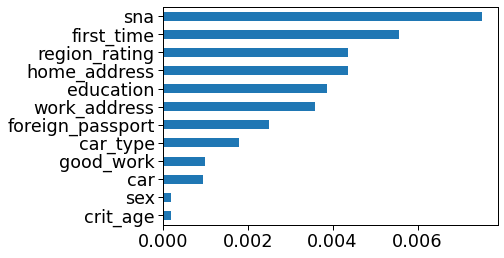

In [383]:
#Определим значимость бинарных и категориальных переменных
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
#Наиболее важным оказывается признак 'sna', подробного описания которого у нас нет 

In [384]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

In [385]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df[num_cols].values)

In [386]:
# Объединяем

X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

# Обучение модели

In [387]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_state)

In [388]:
#Поиск гиперпараметров

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pahan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pahan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linea

C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pahan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pahan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linea

C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pahan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pahan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linea

C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pahan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pahan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linea

C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pahan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Лучшее Penalty: l2
Лучшее C: 7.742636826811269


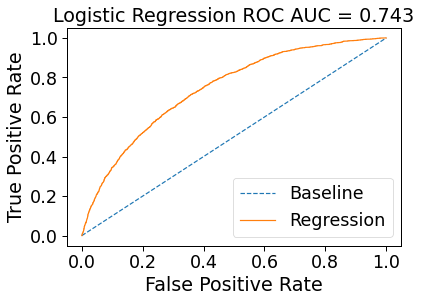

In [389]:
penalty = best_model.best_estimator_.get_params()['penalty']
C = best_model.best_estimator_.get_params()['C']

model = LogisticRegression(C = C, penalty = penalty)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

<AxesSubplot:>

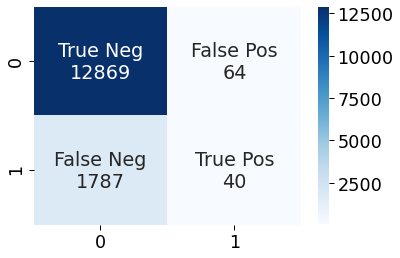

In [390]:
Y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, Y_pred)

# Confusion matrix
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [391]:
print(  'Accuracy: {}'.format(np.round(accuracy_score(y_test, Y_pred), 4)), 
        'f1_score: {}'.format(np.round(f1_score(y_test, Y_pred), 4)),
        'Recall: {}'.format(np.round(recall_score(y_test, Y_pred), 4)),
        'MSE: {}'.format(np.round(mean_squared_error(y_test, Y_pred), 4)), sep="\n")

Accuracy: 0.8746
f1_score: 0.0414
Recall: 0.0219
MSE: 0.1254


In [392]:
#Из всех итераций обучения именно эта модель с этим набором признаков показала в совокупности лучшие показатели метрик

# Предсказание данных на sample submission

In [393]:
df_test = pd.read_csv("test_5.csv")

In [394]:
df_test['education'].fillna(value = df_test['education'].mode().values[0], inplace= True)

df_test['crit_age']=df_test['age'].apply(lambda x: 1 if x>23 and x<43 else 0)

df_test['app_date']=df_test['app_date'].apply(str_time_to_datetime)
df_test['delta_app_date'] = df_test['app_date'].apply(lambda x: (x - min_date).days)

label_encoder = LabelEncoder()

for column in bin_cols:
    df_test[column] = label_encoder.fit_transform(df_test[column])

df_test['education'] = label_encoder.fit_transform(df_test['education'])


X_cat_test = OneHotEncoder(sparse = False).fit_transform(df_test[cat_cols].values)

X_num_test = StandardScaler().fit_transform(df_test[num_cols].values)

X_test_df = np.hstack([X_num_test, df_test[bin_cols].values, X_cat_test])

id_client = df_test['client_id']

In [395]:
Y_pred_probs_test = model.predict_proba(X_test_df)[:,1]

In [396]:
submission = pd.DataFrame({'client_id': id_client, "default": Y_pred_probs_test})
submission.to_csv('submission.csv', index=False)
submission.head()

,client_id,default
0,74835,0.036646
1,17527,0.353924
2,75683,0.056524
3,26883,0.089959
4,28862,0.030186
